Compare the magnitudes produced by tractor to the magnitudes produced by the curve of growth

In [2]:
from glob import glob
from astropy.table import Table
import numpy as np

In [4]:
data_path = '/Users/matt/Data/legacydata/sv3-clustering/raw_output/'
ellipse_nm = 'total_ellipse.fits'
tractor_nm = 'total_tractor.fits'
sample_nm = 'total_sample.fits'

In [7]:
tractor = Table.read(data_path+tractor_nm)
ellipse = Table.read(data_path+ellipse_nm)
sample = Table.read(data_path+sample_nm)

In [12]:
print(tractor['ref_id'], ellipse['ID_CENT'], sample['TARGETID'])

      ref_id     
-----------------
39627877821449852
39627793805349506
39627805918500370
39627758199902938
39627878966494779
39628433264740484
39628351643587238
39627799840952314
39627776268966390
39627902962106484
              ...
39627782312953622
39627775711118163
39627781750917526
39627751501595444
39627812520331535
39627927020636705
39627806459562749
39627794346412638
39628368156558771
39627823979168612
39628438629255421
Length = 1764 rows      ID_CENT     
-----------------
39627877821449852
39627793805349506
39627805918500370
39627758199902938
39627878966494779
39628433264740484
39628351643587238
39627799840952314
39627776268966390
39627902962106484
              ...
39627782312953622
39627775711118163
39627781750917526
39627751501595444
39627812520331535
39627927020636705
39627806459562749
39627794346412638
39628368156558771
39627823979168612
39628438629255421
Length = 1764 rows      TARGETID    
-----------------
39627877821449852
39627793805349506
39627805918500370
39627758

In [16]:
print(np.all(tractor['ref_id'] == ellipse['ID_CENT']))
print(np.all(tractor['ref_id'] == sample['TARGETID']))

True
True


In [22]:
def _get_mags(
    cat,
    rad="10",
    bands=["g", "r", "z"],
    kpc=False,
    pipeline=False,
    cog=False,
    R24=False,
    R25=False,
    R26=False,
):
    res = []
    for band in bands:
        mag = None
        ff = 0
        if kpc:
            iv = cat["FLUX{}_IVAR_{}".format(rad, band.upper())][0]
            ff = cat["FLUX{}_{}".format(rad, band.upper())][0]
        elif pipeline:
            iv = cat["flux_ivar_{}".format(band).lower()]
            ff = cat["flux_{}".format(band).lower()]
        elif R24:
            mag = cat["{}_mag_sb24".format(band).upper()]
        elif R25:
            mag = cat["{}_mag_sb25".format(band).upper()]
        elif R26:
            mag = cat["{}_mag_sb26".format(band).upper()]
        elif cog:
            mag = cat["cog_mtot_{}".format(band).upper()]
        else:
            print("Thar be rocks ahead!")
        if mag:
            res.append("{:.3f}".format(mag))
        else:
            if ff > 0:
                mag = 22.5 - 2.5 * np.log10(ff)
                if iv > 0:
                    ee = 1 / np.sqrt(iv)
                    magerr = 2.5 * ee / ff / np.log(10)
                res.append("{:.3f}".format(mag))
            elif ff < 0 and iv > 0:
                # upper limit
                mag = 22.5 - 2.5 * np.log10(1 / np.sqrt(iv))
                res.append(">{:.3f}".format(mag))
            else:
                res.append('0') #Nan?
                # print(res)
    return res

In [43]:
flux_r_dered = []
tractor_mag_r = []
cog_mag_r = []
z = []
ra = []
dec = []
weight = []
radius_mosaic = []
target_id = []

for trac, smpl, elps in zip(tractor, sample, ellipse):
    g_tractor, r_tractor, z_tractor = _get_mags(trac, pipeline=True)

    if r_tractor is None:
        continue

    g_COG, r_COG, z_COG = _get_mags(elps, cog=True)
    if float(r_COG) == 0:
        continue

    flux_r_dered.append(smpl['FLUX_R_DERED'])
    z.append(smpl['Z'])
    radius_mosaic.append(smpl['RADIUS_MOSAIC'])
    ra.append(smpl['RA'])
    dec.append(smpl['DEC'])

    tractor_mag_r.append(r_tractor)
    cog_mag_r.append(r_COG)
    weight.append(smpl['WEIGHT'])
    target_id.append(smpl['TARGETID'])

In [44]:
print(cog_mag_r)
print(tractor_mag_r)
print(flux_r_dered)

['17.132', '18.650', '19.581', '19.287', '14.153', '18.937', '19.215', '18.575', '18.978', '19.602', '13.841', '15.527', '16.502', '19.018', '19.285', '19.079', '16.393', '17.043', '15.767', '19.203', '19.017', '19.647', '19.485', '15.846', '16.921', '18.201', '18.526', '19.464', '15.553', '15.894', '18.748', '16.295', '19.547', '19.181', '17.536', '15.237', '19.190', '19.461', '17.851', '19.111', '19.223', '17.334', '14.073', '19.303', '14.228', '19.200', '19.005', '19.224', '15.934', '18.914', '19.205', '17.971', '18.874', '14.544', '18.976', '19.124', '19.090', '19.259', '18.677', '17.903', '19.630', '14.125', '18.958', '15.930', '12.478', '18.533', '14.007', '17.450', '18.939', '17.972', '19.161', '19.118', '19.403', '18.550', '13.935', '19.031', '16.069', '17.312', '15.822', '13.632', '16.392', '19.096', '17.804', '17.389', '14.917', '19.247', '14.001', '17.508', '19.045', '19.216', '15.009', '19.091', '13.400', '19.384', '19.041', '19.081', '19.493', '19.080', '13.476', '19.079',

In [45]:
flux_r_dered = np.array(flux_r_dered, dtype=np.float64)
# flux_g_dered = np.array(flux_g_dered, dtype=np.float64)
# flux_z_dered = np.array(flux_z_dered, dtype=np.float64)
tractor_mag_r = np.array(tractor_mag_r, dtype=np.float64)
cog_mag_r = np.array(cog_mag_r, dtype=np.float64)
# tractor_mag_g = np.array(tractor_mag_g, dtype=np.float64)
# cog_mag_g = np.array(cog_mag_g, dtype=np.float64)
# tractor_mag_z = np.array(tractor_mag_z, dtype=np.float64)
# cog_mag_z = np.array(cog_mag_z, dtype=np.float64)

z = np.array(z, dtype=np.float64)
radius_mosaic = np.array(radius_mosaic, dtype=np.float64)
ra = np.array(ra, dtype=np.float64)
dec = np.array(dec, dtype=np.float64)
weight = np.array(weight, dtype=np.float64)
target_id = np.array(target_id, dtype=np.int64)

delta_mag_r = cog_mag_r - tractor_mag_r

In [46]:
mag_bins = [12.06, 12.804, 13.548, 14.292, 15.036, 15.78, 16.524, 17.268, 18.012, 18.756, 19.49992683]
flux_bins = [14996.84835502,7557.8801368,3808.90376498,1919.55252376,967.38644997,487.5284901,245.69708276,123.8226231,62.40221421,31.44850465,15.84893192]

def flux_to_mag(flux):
    return (-5/2)*np.log10(flux) + 22.5

def mag_to_flux(mag):
    return 10**((2/5)* (22.5 - mag))

In [20]:
import time
today = time.strftime("%Y-%m-%d")
np.savez(f'{today}_data', delta_mag_r = delta_mag_r, z=z, ra=ra, dec=dec, cog_mag_r=cog_mag_r,
     tractor_mag_r=tractor_mag_r, flux_r_dered=flux_r_dered, target_id=target_id)

In [2]:
test = np.load('2023-02-08_data.npz')
delta_mag_r = test['delta_mag_r']
z = test['z']
ra = test['ra']
dec = test['dec']
cog_mag_r = test['cog_mag_r']
tractor_mag_r = test['tractor_mag_r']
flux_r_dered = test['flux_r_dered']
target_id = test['target_id']


In [47]:
delta_mag_r = cog_mag_r - flux_to_mag(flux_r_dered)
print(flux_to_mag(flux_r_dered))

[17.13896549 18.65347754 19.39458433 ... 18.63133944 18.06879414
 13.50402386]


(-3.0, 1.0)

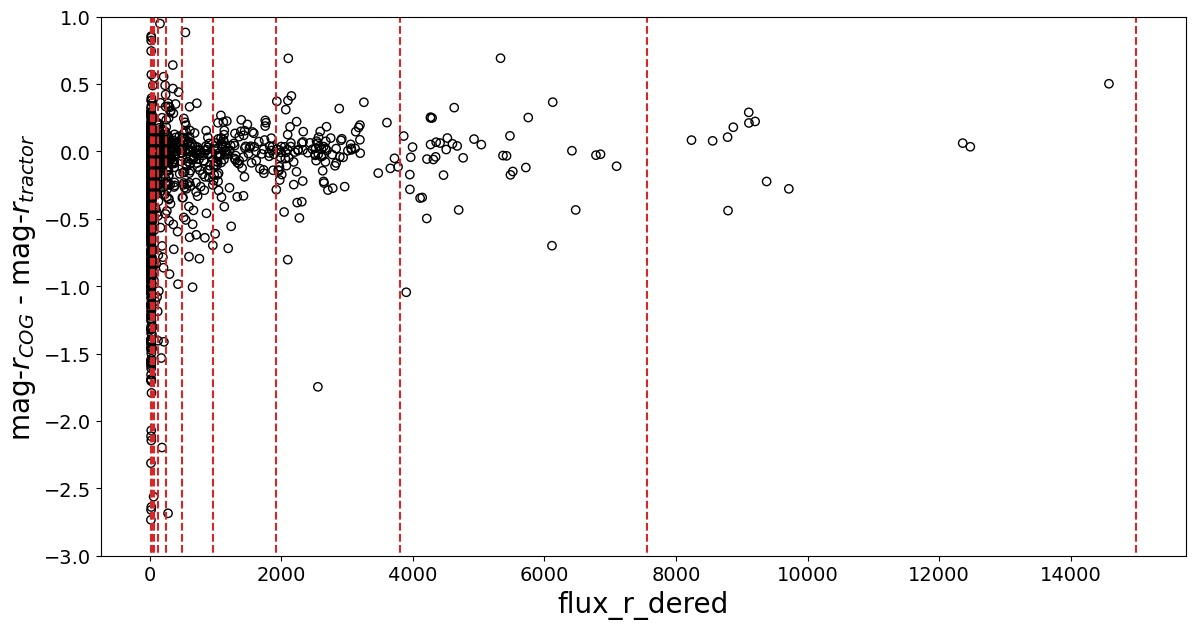

In [48]:
import matplotlib.pyplot as plt
plt.figure(figsize=(14,7))

plt.scatter(flux_r_dered, delta_mag_r, marker='o', lw=1, facecolor='none', edgecolor='k')
plt.hlines(0, 0, 100, ls='dashed', color='tab:red')
plt.xlabel('flux_r_dered', fontsize=20)
plt.ylabel(r'mag-$r_{COG}$ - mag-$r_{tractor}$', fontsize=20)
plt.vlines(flux_bins, -4, 4, ls='dashed', color='tab:red')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylim(-3,1)

(11.5, 20.0)

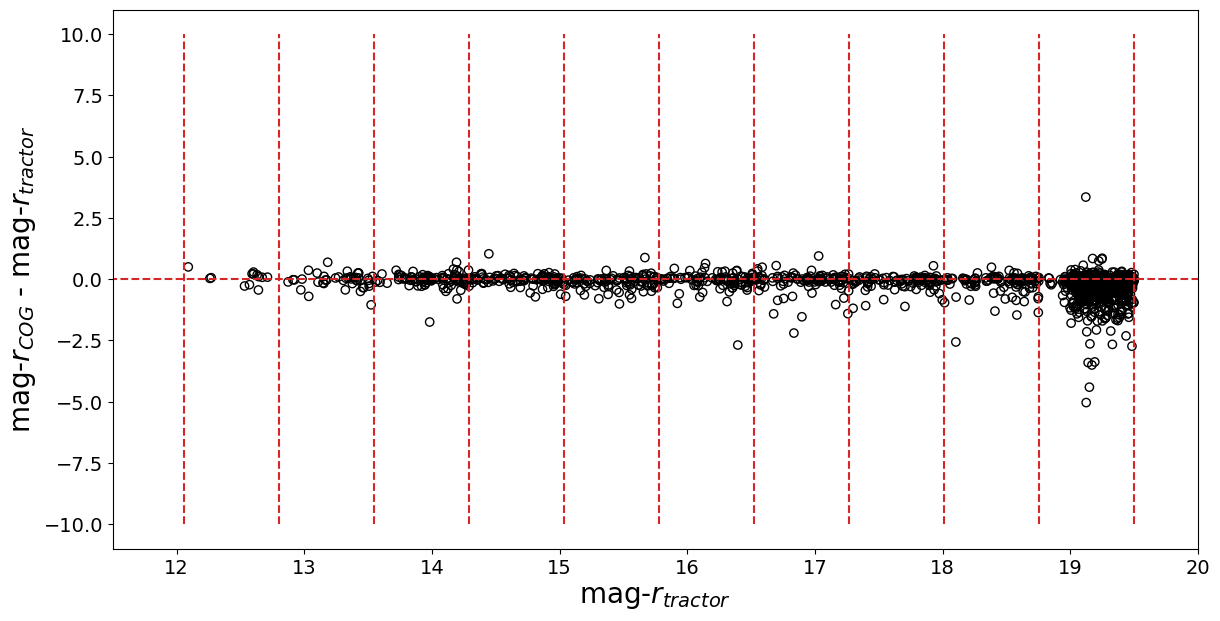

In [49]:
import matplotlib.pyplot as plt
plt.figure(figsize=(14,7))

plt.scatter(flux_to_mag(flux_r_dered), delta_mag_r, marker='o', lw=1, facecolor='none', edgecolor='k')
plt.hlines(0, 0, 100, ls='dashed', color='tab:red')
plt.vlines(mag_bins, -10, 10, ls='dashed', color='tab:red')
plt.xlabel(r'mag-$r_{tractor}$', fontsize=20)
plt.ylabel(r'mag-$r_{COG}$ - mag-$r_{tractor}$', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# plt.ylim(-3,1)
plt.xlim(11.5, 20)

In [50]:
# IDs for that low streak
mask = delta_mag_r < -2.5
dmgr = delta_mag_r[mask].flatten()
t_ids = target_id[mask].flatten()
fluxes = flux_r_dered[mask].flatten()
cogr = cog_mag_r[mask].flatten()
tractr = tractor_mag_r[mask].flatten()
print(list(zip(t_ids, fluxes, dmgr, cogr, tractr)))

[(39627782266819092, 18.53549575805664, -2.6599894841468696, 16.67, 17.116), (39627764248087271, 21.488492965698242, -3.501485103620322, 15.668, 16.408), (39627775652400602, 21.792774200439453, -2.6382187023498247, 16.516, 16.912), (39627841624608915, 276.60693359375, -2.6853423445168367, 13.71, 14.251), (39627799828368481, 16.093564987182617, -2.7333693548290228, 16.75, 19.507), (39627800377820319, 22.082277297973633, -3.4018903519331616, 15.738, 17.106), (39628411747961568, 21.880746841430664, -4.405844646479888, 14.744, 12.425), (39627769595823325, 57.349143981933594, -2.561682650452868, 15.542, 18.132), (39627860868073046, 21.04653549194336, -3.3770484598514887, 15.815, 18.649), (39628427900228087, 22.39269256591797, -5.034734205957136, 14.09, 19.055)]


In [51]:
from scipy.stats import sem
mag_r = flux_to_mag(flux_r_dered)

mean = []
std = []
mid_pt = []
binned_sample = []
stdem = []
for i in range(len(mag_bins)-1):
    this_bin_low = mag_r > mag_bins[i]
    this_bin_max = mag_r <= mag_bins[i+1]
    
    mask = np.all([this_bin_low.flatten(), this_bin_max.flatten()], axis=0)
    this_bin = delta_mag_r[mask]
    binned_sample.append(this_bin)
    mean.append(np.mean(this_bin))
    std.append(np.std(this_bin))
    stdem.append(sem(this_bin))
    mid_pt.append((mag_bins[i+1]+  mag_bins[i])/2)

In [52]:
print(len(mid_pt))
print(len(mean))

10
10


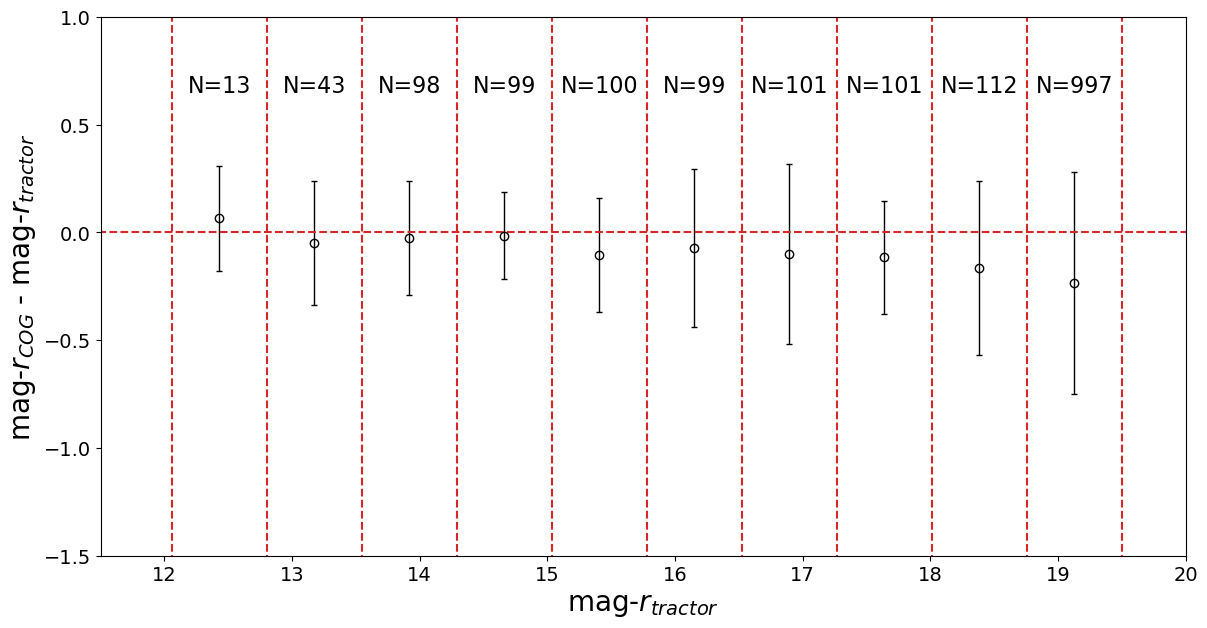

In [53]:
import matplotlib.pyplot as plt
plt.figure(figsize=(14,7))

plt.errorbar(mid_pt, mean, std, marker='o', lw=1, c='k', linestyle='none', 
    capsize=2, markeredgecolor='k', markerfacecolor='none', ecolor='k')
plt.hlines(0, 0, 100, ls='dashed', color='tab:red')
plt.vlines(mag_bins, -10, 10, ls='dashed', color='tab:red')
plt.xlabel(r'mag-$r_{tractor}$', fontsize=20)
plt.ylabel(r'mag-$r_{COG}$ - mag-$r_{tractor}$', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylim(-1.5,1)
plt.xlim(11.5, 20)
for i in range(len(binned_sample)):
    n = len(binned_sample[i])
    mid_pt[i]
    plt.annotate(f'N={n}', xy=(mid_pt[i], .65), xycoords='data', horizontalalignment='center', fontsize=16)

Redshift bins now

In [54]:
z_min = min(z)
z_max = max(z)

z_bins = np.linspace(z_min, z_max, 11).flatten()
print(z_bins)



[0.01396716 0.07229427 0.13062138 0.18894849 0.24727561 0.30560272
 0.36392983 0.42225694 0.48058405 0.53891116 0.59723827]


(0.0, 0.6)

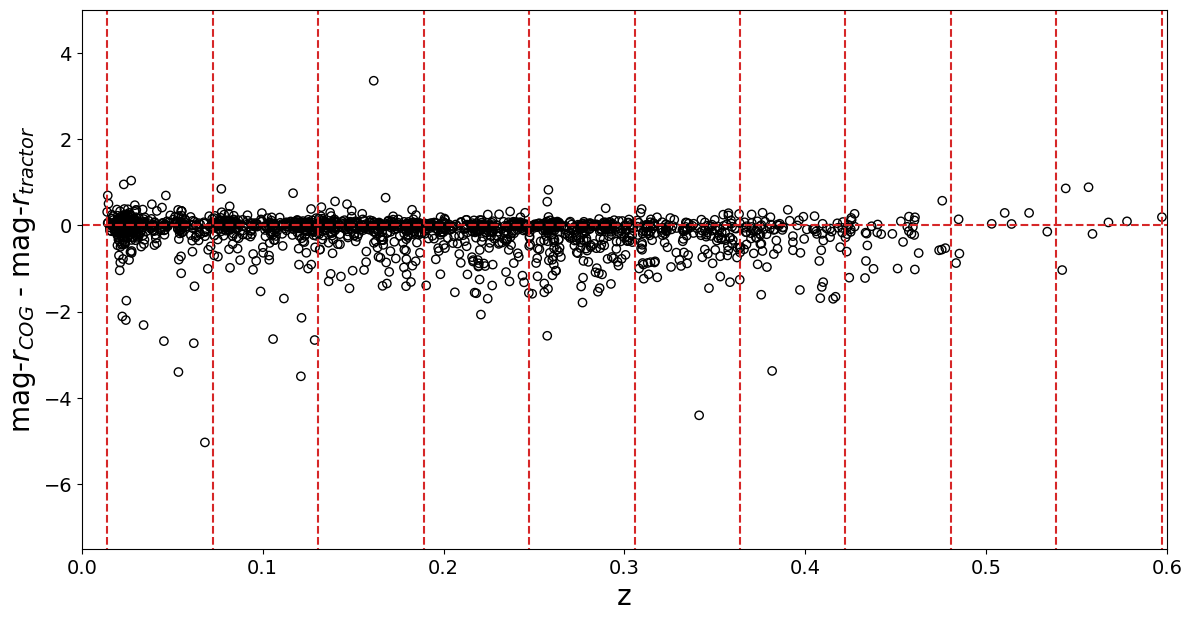

In [55]:
import matplotlib.pyplot as plt
plt.figure(figsize=(14,7))

plt.scatter(z, delta_mag_r, marker='o', lw=1, facecolor='none', edgecolor='k')
plt.hlines(0, 0, 100, ls='dashed', color='tab:red')
plt.vlines(z_bins, -10, 10, ls='dashed', color='tab:red')
plt.xlabel('z', fontsize=20)
plt.ylabel(r'mag-$r_{COG}$ - mag-$r_{tractor}$', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylim(-7.5,5)
plt.xlim(0, .6)

In [56]:
mean2 = []
std2 = []
mid_pt2 = []
binned_sample2 = []
stdem2 = []
for i in range(len(z_bins)-1):
    this_bin_low2 = z > z_bins[i]
    this_bin_max2 = z <= z_bins[i+1]
    
    mask2 = np.all([this_bin_low2.flatten(), this_bin_max2.flatten()], axis=0)
    this_bin2 = delta_mag_r[mask2]
    binned_sample2.append(this_bin2)
    mean2.append(np.mean(this_bin2))
    std2.append(np.std(this_bin2))
    stdem2.append(sem(this_bin))
    mid_pt2.append((z_bins[i+1]+  z_bins[i])/2)

In [57]:
print(mean2, std2, mid_pt2)

[-0.08912921715406615, -0.11320673550849332, -0.11204736443953628, -0.20877607169614526, -0.2468641064332635, -0.28284449657563276, -0.32768294708237766, -0.26737106690128, -0.1120257278331307, 0.12198335046981842] [0.4747886085228172, 0.42445944644497063, 0.3822564765886134, 0.39725934017610565, 0.4160702227723408, 0.49846156553689014, 0.5579344013156374, 0.4212146548881773, 0.4035576354207115, 0.6063575345581985] [0.04313071608999013, 0.10145782748076894, 0.15978493887154774, 0.21811205026232655, 0.27643916165310534, 0.3347662730438842, 0.39309338443466296, 0.45142049582544175, 0.5097476072162206, 0.5680747186069994]


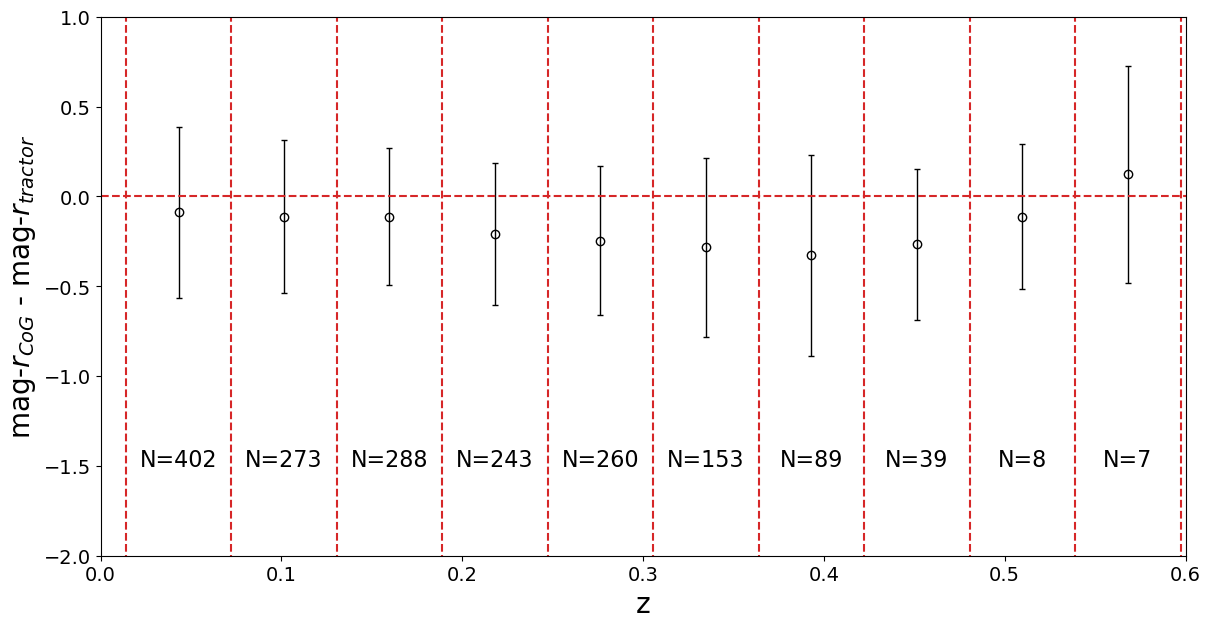

In [58]:
import matplotlib.pyplot as plt
plt.figure(figsize=(14,7))

plt.errorbar(mid_pt2, mean2, std2, marker='o', lw=1, c='k', linestyle='none', 
    capsize=2, markeredgecolor='k', markerfacecolor='none', ecolor='k')
plt.hlines(0, 0, 100, ls='dashed', color='tab:red')
plt.vlines(z_bins, -10, 10, ls='dashed', color='tab:red')
plt.xlabel('z', fontsize=20)
plt.ylabel(r'mag-$r_{CoG}$ - mag-$r_{tractor}$', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylim(-2,1)
plt.xlim(0, .6)
for i in range(len(binned_sample2)):
    n = len(binned_sample2[i])
    plt.annotate(f'N={n}', xy=(mid_pt2[i], -1.5), xycoords='data', horizontalalignment='center', fontsize=16)

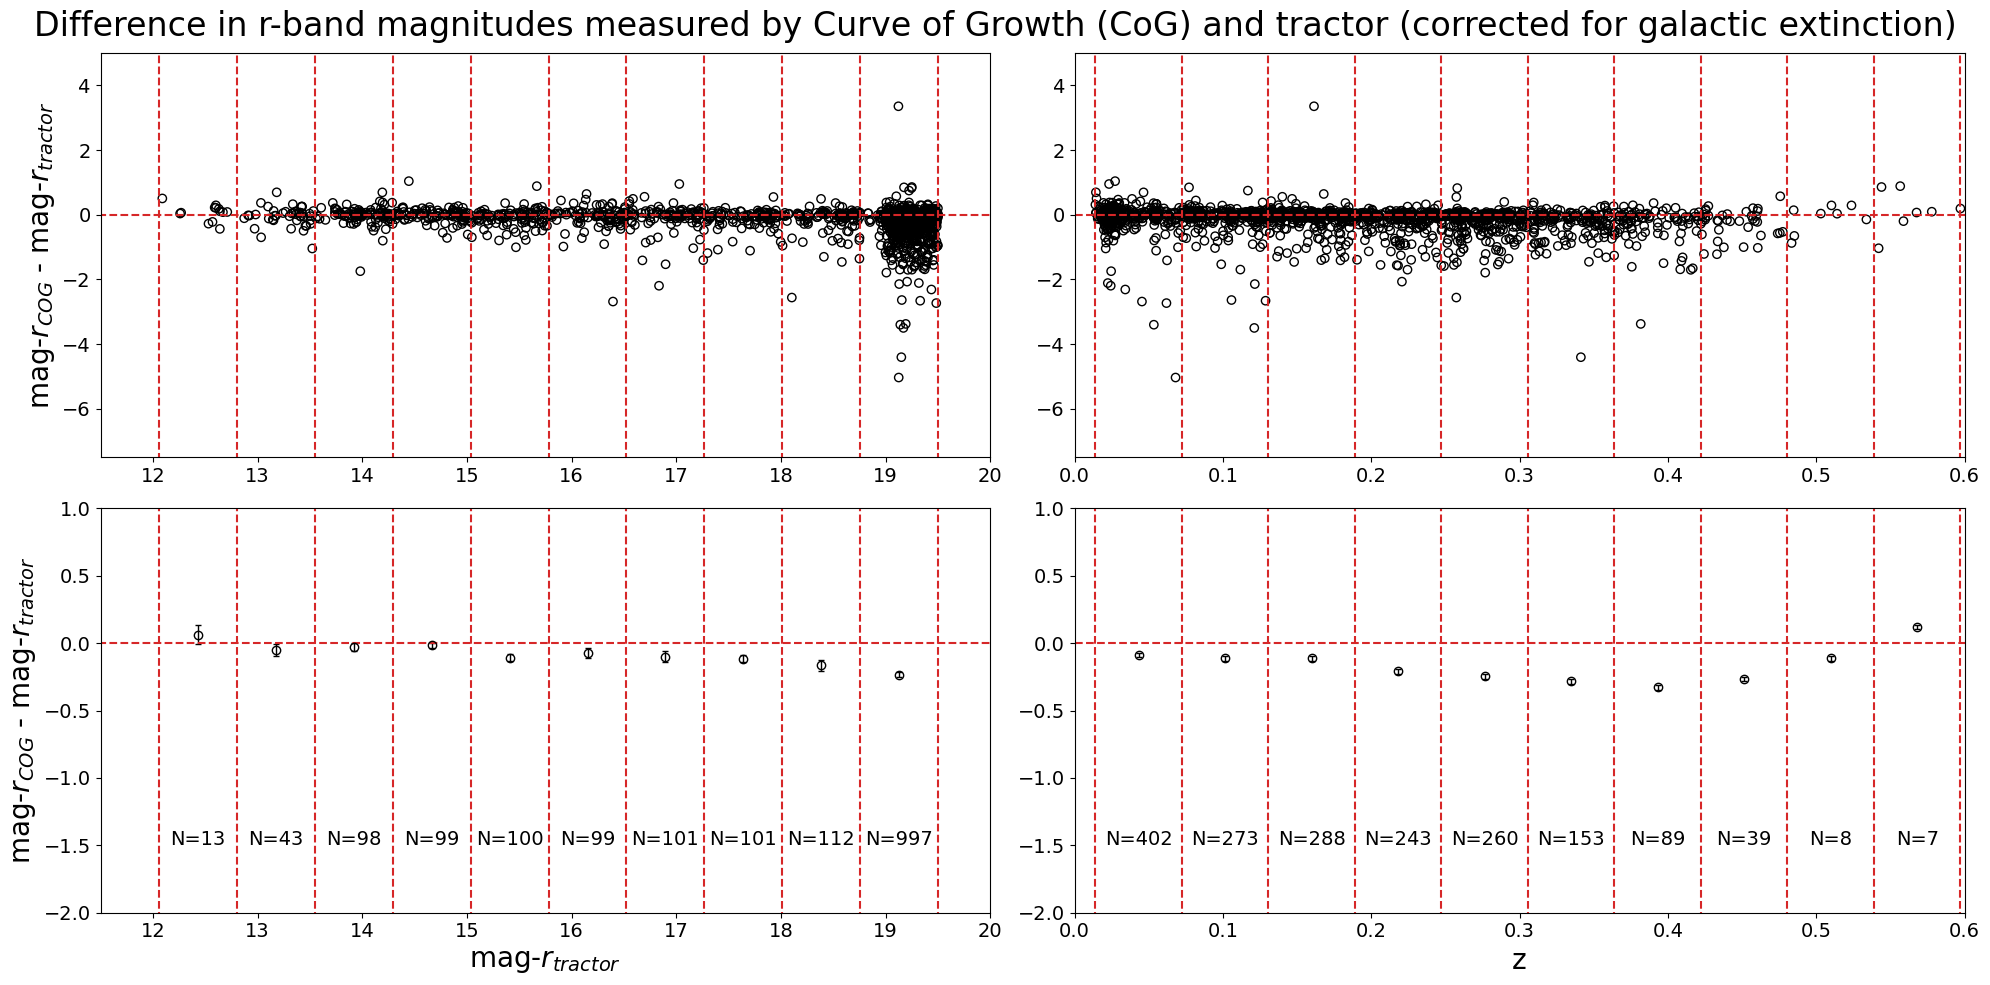

In [59]:
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14)
matplotlib.rc('figure', facecolor='white')

fig, (row1, row2) = plt.subplots(2, 2, figsize=(20,10))

row1[0].scatter(flux_to_mag(flux_r_dered), delta_mag_r, marker='o', lw=1, facecolor='none', edgecolor='k')
row1[0].hlines(0, 0, 100, ls='dashed', color='tab:red')
row1[0].vlines(mag_bins, -10, 10, ls='dashed', color='tab:red')
# row1[0].set_xlabel(r'mag-$r_{tractor}$', fontsize=20)
row1[0].set_ylabel(r'mag-$r_{COG}$ - mag-$r_{tractor}$', fontsize=20)
# row1[0].set_xticks(fontsize=14)
# row1[0].set_yticks(fontsize=14)
row1[0].set_ylim(-7.5,5)
row1[0].set_xlim(11.5, 20)

row2[0].errorbar(mid_pt, mean, stdem, marker='o', lw=1, c='k', linestyle='none', 
    capsize=2, markeredgecolor='k', markerfacecolor='none', ecolor='k')
row2[0].hlines(0, 0, 100, ls='dashed', color='tab:red')
row2[0].vlines(mag_bins, -10, 10, ls='dashed', color='tab:red')
row2[0].set_xlabel(r'mag-$r_{tractor}$', fontsize=20)
row2[0].set_ylabel(r'mag-$r_{COG}$ - mag-$r_{tractor}$', fontsize=20)
# plt.xticks(fontsize=14)
# plt.yticks(fontsize=14)
row2[0].set_ylim(-2,1)
row2[0].set_xlim(11.5, 20)
for i in range(len(binned_sample)):
    n = len(binned_sample[i])
    mid_pt[i]
    row2[0].annotate(f'N={n}', xy=(mid_pt[i], -1.5), xycoords='data', horizontalalignment='center', fontsize=14)

###########
###########
###########


row1[1].scatter(z, delta_mag_r, marker='o', lw=1, facecolor='none', edgecolor='k')
row1[1].hlines(0, 0, 100, ls='dashed', color='tab:red')
row1[1].vlines(z_bins, -10, 10, ls='dashed', color='tab:red')
# row1[1].set_xlabel('z', fontsize=20)
# row1[1].set_ylabel(r'mag-$r_{COG}$ - mag-$r_{tractor}$', fontsize=20)
# row2[0].xticks(fontsize=14)
# row2[0].yticks(fontsize=14)
row1[1].set_ylim(-7.5,5)
row1[1].set_xlim(0, .6)


row2[1].errorbar(mid_pt2, mean2, stdem2, marker='o', lw=1, c='k', linestyle='none', 
    capsize=2, markeredgecolor='k', markerfacecolor='none', ecolor='k')
row2[1].hlines(0, 0, 100, ls='dashed', color='tab:red')
row2[1].vlines(z_bins, -10, 10, ls='dashed', color='tab:red')
row2[1].set_xlabel('z', fontsize=20)
# row2[1].set_ylabel(r'mag-$r_{CoG}$ - mag-$r_{tractor}$', fontsize=20)
# row2[1].xticks(fontsize=14)
# row2[1].yticks(fontsize=14)
row2[1].set_ylim(-2,1)
row2[1].set_xlim(0, .6)
for i in range(len(binned_sample2)):
    n = len(binned_sample2[i])
    row2[1].annotate(f'N={n}', xy=(mid_pt2[i], -1.5), xycoords='data', horizontalalignment='center', fontsize=14)


fig.suptitle('Difference in r-band magnitudes measured by Curve of Growth (CoG) and tractor (corrected for galactic extinction)', fontsize=24)
plt.tight_layout()

I understand the trend with magnitude (bright galaxies have underestiamted luminosities) ... but does anyone undertand the trend with redshift?

We now want to make some cuts to select galaxies that have underestiamted luminosities. What cut do we want to make? Delta_mag = 0.1 mag?

What sample size would that look like?

can you make a 2D figure with: - resshift - magnitude - and then color coded by the mean magnitude offset

In [60]:
print(len(delta_mag_r[delta_mag_r < -0.1]))
print(len(delta_mag_r))

669
1763


In [61]:
import matplotlib.pyplot as plt
mag = flux_to_mag(flux_r_dered)
z = z.flatten()

grid_size=15
z_grid = np.linspace(z.min(), z.max(), grid_size)
mag_grid = np.linspace(mag.min(), mag.max(), grid_size)

avg_binned = []

for i in range(len(z_grid)-1):
    
    # For a z_bin
    z_bin = z_grid[i]; z_bin_next = z_grid[i+1]
    
    for j in range(len(mag_grid)-1):
    
        # for a mag bin
        mag_bin = mag_grid[j]; mag_bin_next = mag_grid[j+1]
        
        # Loop over all (z, mag, delta-mag-r) combos, add any in this bin into a list    
        delta_mag_r_this_bin = []
        for trio in list(zip(z, mag, delta_mag_r)):
            if trio[0] > z_bin and trio[0] < z_bin_next and trio[1] > mag_bin and trio[1] < mag_bin_next:
                delta_mag_r_this_bin.append(trio[2])
        
        # Average all valid guys 
        mag_midpt = (mag_bin+mag_bin_next)/2
        z_midpt = (z_bin+z_bin_next)/2
        mean_delta_mag_r = np.nan
        if len(delta_mag_r_this_bin) > 0:
            mean_delta_mag_r = np.mean(delta_mag_r_this_bin)

        avg_binned.append((z_midpt, mag_midpt, mean_delta_mag_r))



In [62]:
z_rebin, m_rebin, delta_mag_rebin = list(zip(*avg_binned))

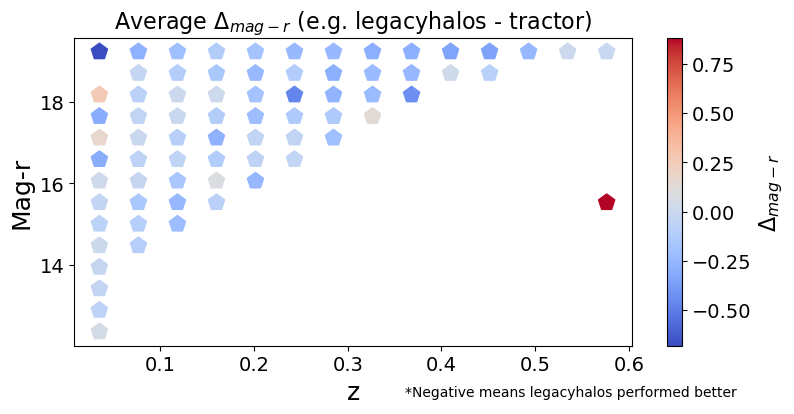

In [63]:


fig, (ax0) = plt.subplots(ncols=1, sharey=True, figsize=(9, 4))
sc = ax0.scatter(z_rebin, m_rebin, 150, c=delta_mag_rebin, marker='p', cmap='coolwarm')


# xlim = z.min()-0.1, z.max()+0.1
# ylim = mag.min()-2, mag.max()+2
# hb = ax0.hexbin(z, mag, gridsize=15, cmap='inferno')
# ax0.set(xlim=xlim, ylim=ylim)

cb = fig.colorbar(sc, ax=ax0)
cb.set_label(r'$\Delta_{mag-r}$', fontsize=16)
plt.xlabel('z', fontsize=18)
plt.ylabel('Mag-r', fontsize=18)
plt.title(r'Average $\Delta_{mag-r}$ (e.g. legacyhalos - tractor)', fontsize=16)
plt.show()
